<a href="https://colab.research.google.com/github/nishitaverma/twitter_toxicity_classification/blob/main/Toxicity_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxicity Classification:

**Data Source:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br><br>

**Problem Statement:** Given a comment made by the user, predict:
- If the comment is toxic (classification)
- The toxicity of the comment (regression)-in progress
<br><br>


## Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
import gensim
import string

import warnings
# from keras import backend as K
warnings.filterwarnings("ignore")
# K.tensorflow_backend._get_available_gpus()
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Reading Data:

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/toxic_tweet_classification/data/train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/toxic_tweet_classification/data/test.csv', index_col='id', engine='python')
test_df.head()

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [ ]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [ ]:
len(train_df)

1804874

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                            

In [ ]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis:

### Helper Functions

In [ ]:
def count_plot(x, plot_title, plot_size=(10,7)):
  fig, ax = plt.subplots(1,1,figsize=plot_size)
  total = float(len(x))

  # Plot the count plot.
  cntplot = sns.countplot(x=x,  ax=ax, palette='pastel')
  cntplot.set_title(plot_title)

  for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

  plt.show()

In [ ]:
def distribution_plots(data, features, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    for feature in features:
        # print(data[feature])
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

In [ ]:
def comment_toxicity_type(row):
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]

    maxarg = np.argmax(np.array(row))

    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

### Target Feature:

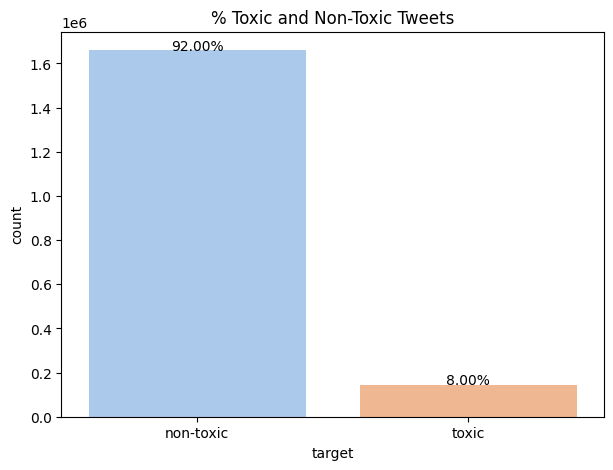

In [ ]:
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")
count_plot(x=temp, plot_title="% Toxic and Non-Toxic Tweets", plot_size=(7, 5))


The number of toxic comments present in the dataset (>0.5 toxicity) are very less (8%) compared to the non-toxic comments (92%). The dataset is imbalanced in nature.

### Toxicity Subtypes:
['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

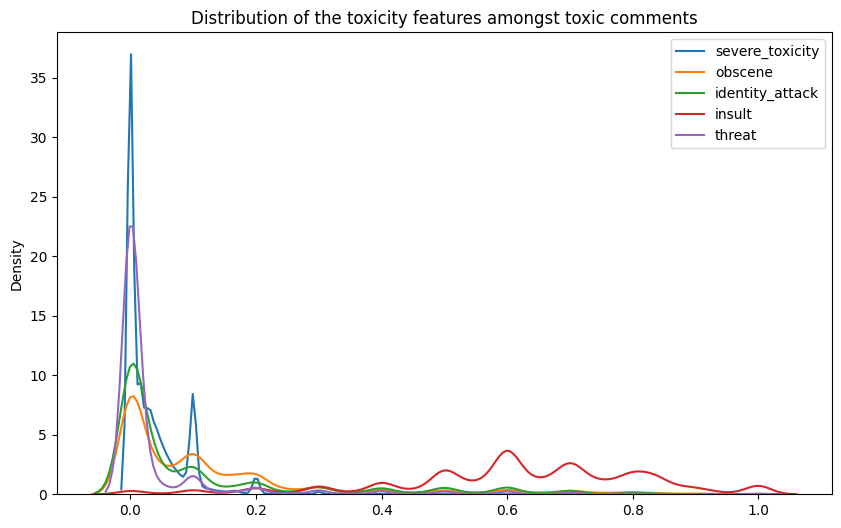

In [ ]:
# Distribution of the toxicity features amongst toxic comments
features= ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
temp = train_df[train_df['target'] > 0.5]
distribution_plots(temp, features, "Distribution of the toxicity features amongst toxic comments")

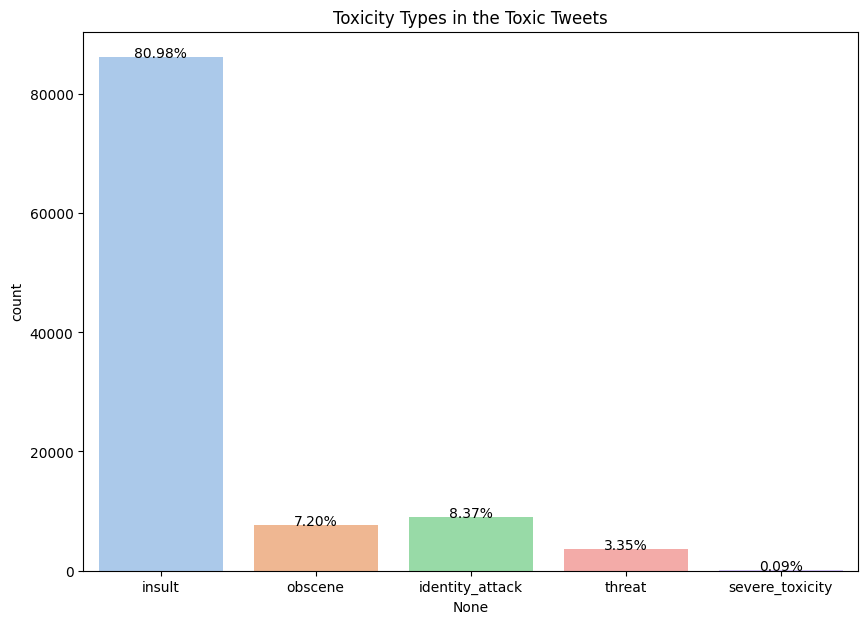

In [ ]:
x = temp.apply(comment_toxicity_type, axis=1)
count_plot(x=x, plot_title="Toxicity Types in the Toxic Tweets")

The train dataset consists of only 8% toxic comments, out of which, 81% of the toxic comments are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a 0.09% are severly toxic.

### Identity Attributes:


In [ ]:
temp = train_df.dropna(axis = 0, how = 'any')

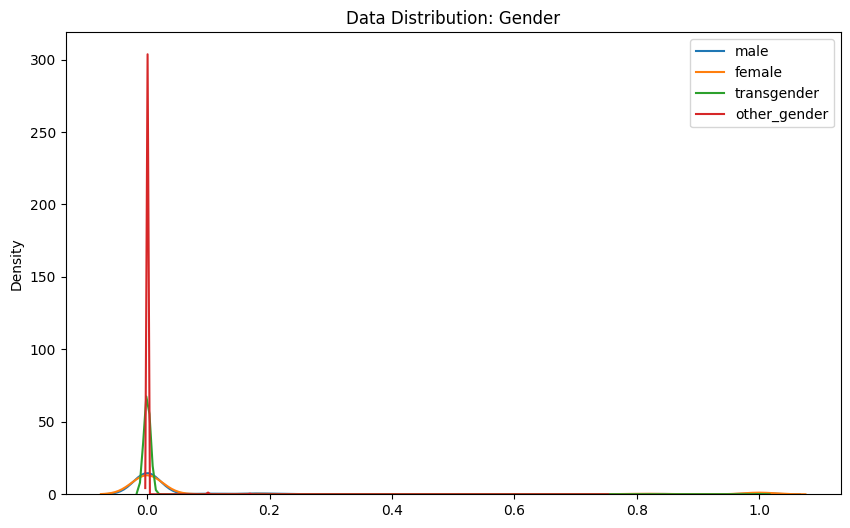

In [ ]:
features = ['male', 'female', 'transgender', 'other_gender']
distribution_plots(temp, features, "Data Distribution: Gender")

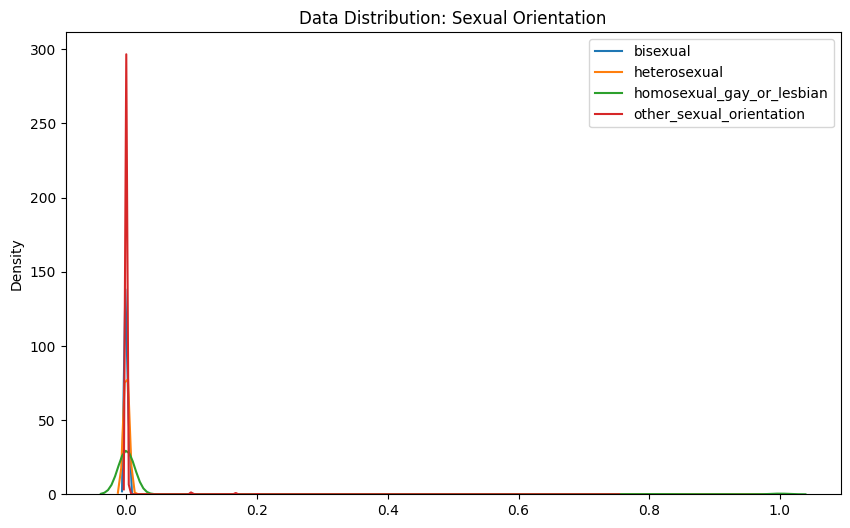

In [ ]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
distribution_plots(temp, features, "Data Distribution: Sexual Orientation")

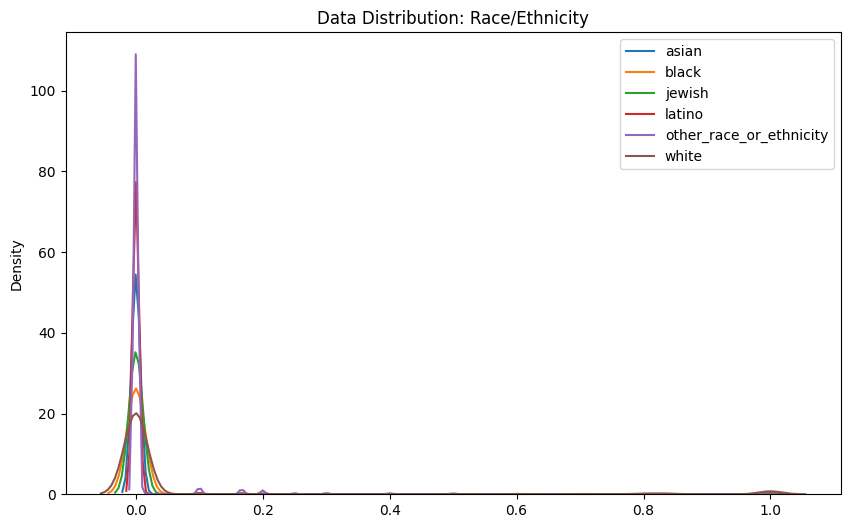

In [ ]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
distribution_plots(temp, features, "Data Distribution: Race/Ethnicity")

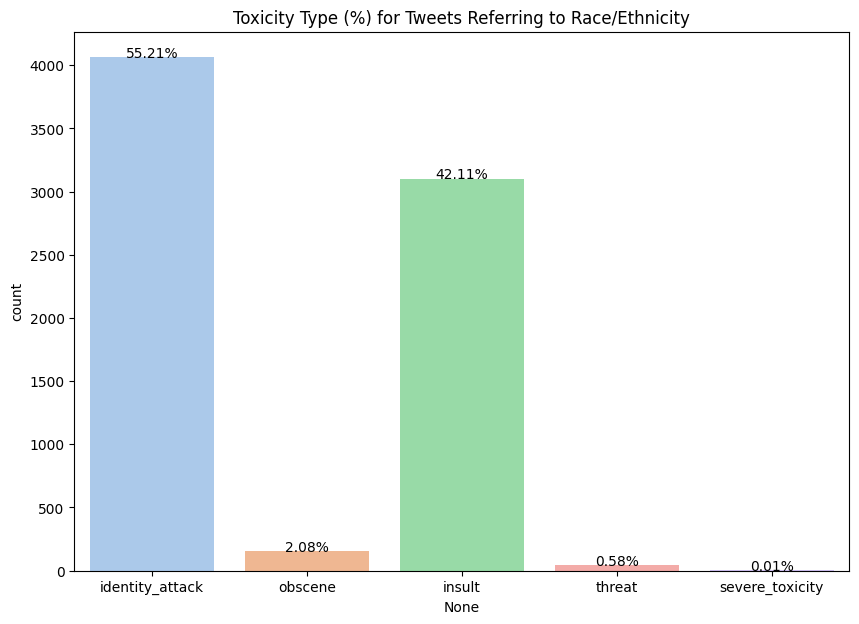

In [ ]:
# Analysis for race/ethnic references
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond]
temp = temp[temp['target'] > 0.5]

x = temp.apply(comment_toxicity_type, axis=1)

count_plot(x=x, plot_title="Toxicity Type (%) for Tweets Referring to Race/Ethnicity")

Toxic comments involving race naming are being used for identity attacks or insults.

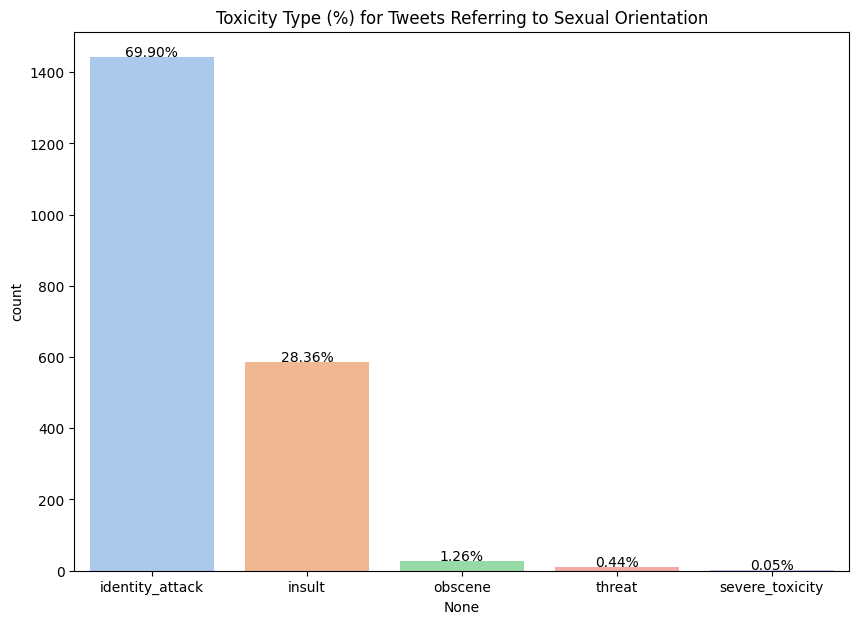

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(comment_toxicity_type, axis=1) # Get nature of each toxic comment

count_plot(x=x, plot_title="Toxicity Type (%) for Tweets Referring to Sexual Orientation")


**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.**

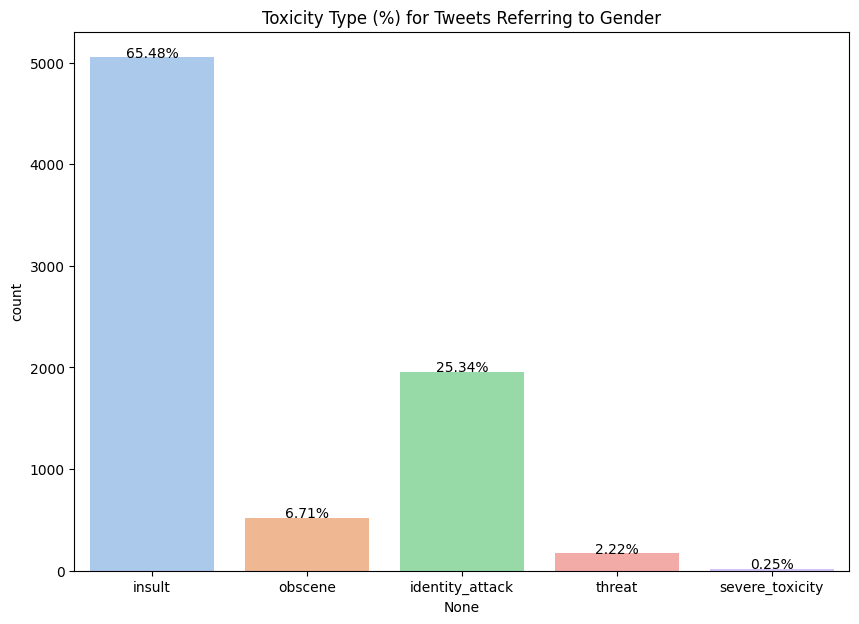

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(comment_toxicity_type, axis=1) # Get nature of each toxic comment

count_plot(x=x, plot_title="Toxicity Type (%) for Tweets Referring to Gender")


**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

## Preprocessing Text and Train-Test Split:

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    try:
      text_string= str(text_string)
      text_string = text_string.lower()
      text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations

      x = text_string.split()
      new_text = []

      for word in x:
          if word not in stop_words:
              new_text.append(stemmer.stem(word))

      text_string = ' '.join(new_text)
      return text_string
    except Exception as e:
      print(e)
      return text_string

In [ ]:
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

In [ ]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [ ]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 21 s, sys: 64 ms, total: 21 s
Wall time: 21.1 s


In [ ]:
test_df

,comment_text,preprocessed_text
id,,
7097320,[ Integrity means that you pay your debts.]\n\...,integr mean pay debt appli presid trump
7097321,This is malfeasance by the Administrator and t...,malfeas administr board wast money
7097322,@Rmiller101 - Spoken like a true elitist. But ...,rmiller101 spoken like true elitist look bud a...
7097323,"Paul: Thank you for your kind words. I do, in...",paul thank kind word inde strong belief hide b...
7097324,Sorry you missed high school. Eisenhower sent ...,sorri miss high school eisenhow sent troop vie...
...,...,...
7194635,He should lose his job for promoting mis-infor...,lose job promot mis inform harm student
7194636,"""Thinning project is meant to lower fire dange...",thin project meant lower fire danger improv wi...
7194637,I hope you millennials are happy that you put ...,hope millenni happi put airhead charg


In [ ]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)
X_train, X_te, y_train, y_te = train_test_split(X_train, y_train)
print(X_train.shape)
print(X_cv.shape)
print(X_te.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_te.shape)

(1015241, 1)
(451219, 1)
(338414, 1)
(1015241, 1)
(451219, 1)
(338414, 1)


In [ ]:
X_train.head()

,preprocessed_text
id,
5464676,import thing seat continu dem dem old boy netw...
6225647,agre 100 proud girl stay us gone make differ f...
371533,hdr suck heavi hand bridg nowher tanana river ...
5921450,nope http dailycal com 2017 09 05 four way dac...
5533586,oki dokey


In [ ]:
X_cv.head()

,preprocessed_text
id,
712139,mississauga find way liber approv
6179926,iran deal work intend design good enough campa...
768727,cat often short term trader perspect odd inves...
557507,anoth republican famili valu conserv exampl vo...
5561082,like black bloc toronto g20 violenc start extr...


In [ ]:
X_te.head()

,preprocessed_text
id,
411535,alway support local own busi first mo bush bud...
5968493,yes major differ popul accept high taxat high ...
505678,yes mean fed dole provinc amount collect tax b...
344147,cat object noth like put strip gorilla tape ti...
801543,wrong folk say 1 1 2 way reach 2 rigid canon 1...


In [ ]:
# This is the text set provided by the data source, target labels not available
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [ ]:
# Save the preprocessed data to drive
X_train.to_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_train.pkl')
X_cv.to_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_cv.pkl')
X_test.to_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_test.pkl')
X_te.to_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_te.pkl')
y_te.to_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/y_te.pkl')
y_train.to_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/y_train.pkl')
y_cv.to_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/y_cv.pkl')

## Training the models for classification
The pre-processed tweets will be vectorised using TF-IDF.

For classification of tweets into the two classes (toxic, non-toxic) we'll train:
- Decision Trees
- Logistic Regression
- XGBoost

In [2]:
# Load preprocessed data from the drive
# X_train = pd.read_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_train.pkl')
# X_cv = pd.read_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_cv.pkl')
# X_test = pd.read_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_test.pkl')
# X_te = pd.read_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/X_te.pkl')
y_te = pd.read_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/y_te.pkl')
y_train = pd.read_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/y_train.pkl')
y_cv = pd.read_pickle('/content/drive/MyDrive/toxic_tweet_classification/data/y_cv.pkl')

### Vectorization: Term Frequency - Inverse Document Frequency (TFIDF)

In [ ]:
#Using TF-IDF Vectoriser to vectorize the preprocessed text
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])
tfidf_te = tfidf_vec.transform(X_te['preprocessed_text'])


print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)
print(tfidf_te.shape)

(1015241, 30000)
(451219, 30000)
(97320, 30000)
(338414, 30000)


In [3]:
from scipy.sparse import csr_matrix
import numpy

# Save vectorised data to drive as .npy files (done to save time and resources)
# tfidf_train_matrices = numpy.array(tfidf_train)
# numpy.save(f"/content/drive/MyDrive/toxic_tweet_classification/data/tfidf_train.npy", tfidf_train_matrices, allow_pickle=True)
# tfidf_cv_matrices = numpy.array(tfidf_cv)
# numpy.save(f"/content/drive/MyDrive/toxic_tweet_classification/data/tfidf_cv.npy", tfidf_cv_matrices, allow_pickle=True)
# tfidf_test_matrices = numpy.array(tfidf_test)
# numpy.save(f"/content/drive/MyDrive/toxic_tweet_classification/data/tfidf_test.npy", tfidf_test_matrices, allow_pickle=True)
# tfidf_te_matrices = numpy.array(tfidf_te)
# numpy.save(f"/content/drive/MyDrive/toxic_tweet_classification/data/tfidf_te.npy", tfidf_te_matrices, allow_pickle=True)

def load_vectorised_data(filename):
  loader = numpy.load(f"/content/drive/MyDrive/toxic_tweet_classification/data/{filename}.npy", allow_pickle=True).item()
  return loader

In [4]:
# # Load vectorised data

tfidf_train= load_vectorised_data("tfidf_train")
tfidf_cv= load_vectorised_data("tfidf_cv")
tfidf_test= load_vectorised_data("tfidf_test")
tfidf_te= load_vectorised_data("tfidf_te")

In [5]:
print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)
print(tfidf_te.shape)

(1015241, 30000)
(451219, 30000)
(97320, 30000)
(338414, 30000)


In [7]:
# Since we're dealing with imbalanced dataset, the performance for toxic tweets may not be up to the mark. To address this, we can sample the datasets to create a balance between the classes:
# Code reference: https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/
import numpy as np
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X= tfidf_train
y= np.where(y_train['target'] >= 0.5, 1, 0)

print("Original class distribution:", Counter(y))

# Oversampling using RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
print("Oversampled class distribution:", Counter(y_over))


# Undersampling using RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
print("Undersampled class distribution:", Counter(y_under))

Original class distribution: Counter({0: 933980, 1: 81261})
Oversampled class distribution: Counter({0: 933980, 1: 933980})
Undersampled class distribution: Counter({0: 81261, 1: 81261})


In [ ]:
#for test set
# ytebin= np.where(y_te['target'] >= 0.5, 1, 0)
# oversample = RandomOverSampler(sampling_strategy='minority')
# Xte_over, yte_over = oversample.fit_resample(tfidf_te, ytebin)
# print("Oversampled class distribution:", Counter(y_over))

Oversampled class distribution: Counter({0: 933980, 1: 933980})


#### Decision Tree

##### Oversampled

In [ ]:
# without hyper param tuning
# weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_over), y=y_over)n
DTCmodel = DecisionTreeClassifier(random_state=45, max_depth=10, min_samples_leaf=100)
DTCmodel.fit(X_over, y_over) # Train

preds = DTCmodel.predict(X_over) # Get predictions
err = (mean_squared_error(y_over, preds))** 0.5 # Calculate RMSE error on trainset
print("Root Mean Squared Error on train set: ", err)

preds = DTCmodel.predict(tfidf_cv) # Get predictions on CV set
err = (mean_squared_error(y_cv['target'], preds))** 0.5 # Calculate error on cv set
print("Root Mean Squared Error on cv set: ", err)

Root Mean Squared Error on train set:  0.5679765655014863
Root Mean Squared Error on cv set:  0.2505675796469267


In [ ]:
ypred_dtc = DTCmodel.predict(tfidf_te)
ytrue= np.where(y_te['target'] >= 0.5, 1, 0)

Text(149.72222222222223, 0.5, 'true value')

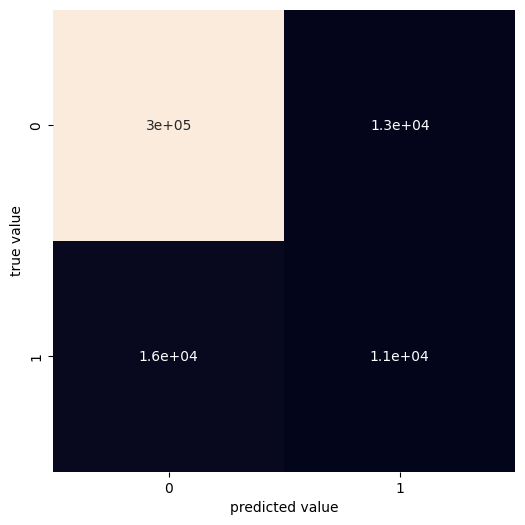

In [ ]:
plt.figure(figsize=(8, 6))
mat = confusion_matrix(ytrue, ypred_dtc)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
cr= classification_report(ytrue, ypred_dtc)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    311363
           1       0.46      0.39      0.42     27051

    accuracy                           0.91    338414
   macro avg       0.70      0.68      0.69    338414
weighted avg       0.91      0.91      0.91    338414



##### Undersampled

In [ ]:
def train_and_evaluate_decision_tree_classifier(max_depth, min_samples_leaf):
  ycvbin= np.where(y_cv['target'] >= 0.5, 1, 0)
  xlabels = []
  tr_f1s = []
  cv_f1s = []
  best_model = None
  best_f1 = 0
  for d in max_depth:
      for samp in min_samples_leaf:
          xlabels.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
          print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

          model = DecisionTreeClassifier(random_state=45, max_depth=d, min_samples_leaf=samp)
          model.fit(X_under, y_under) # Train

          preds = model.predict(X_under) # Get predictions
          f= f1_score(y_under, preds)
          tr_f1s.append(f)
          print("F1 score for train set: ", f)

          preds = model.predict(tfidf_cv) # Get predictions on CV set
          f= f1_score(ycvbin, preds)
          cv_f1s.append(f)
          print("F1 score for cv set: ", f)

          if f > best_f1: # Get best model trained
              best_f1 = f
              best_model = model

          print("-"*50)
  return best_model, xlabels, tr_f1s, cv_f1s


def plot_train_and_cv_f1s(max_depth, min_samples, xlabels, tr_f1s, cv_f1s):
  plt.figure(figsize=(15,5))
  plt.suptitle("Hyperparameters vs F1 Scores")
  plt.plot(range(len(max_depth) * len(min_samples)), tr_f1s)
  plt.plot(range(len(max_depth) * len(min_samples)), cv_f1s)
  plt.legend(['train', 'cv'])
  plt.xticks(range(len(max_depth) * len(min_samples)), xlabels, rotation=45)
  plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
  plt.ylabel('F1 Score')
  plt.show()

Depth- 10 Min Samples leaf-20 :
F1 score for train set:  0.5498594841737068
F1 score for cv set:  0.42198746750417
--------------------------------------------------
Depth- 10 Min Samples leaf-40 :
F1 score for train set:  0.5498883736905376
F1 score for cv set:  0.42194624430045596
--------------------------------------------------
Depth- 10 Min Samples leaf-60 :
F1 score for train set:  0.5481847786756724
F1 score for cv set:  0.4253876558224384
--------------------------------------------------
Depth- 10 Min Samples leaf-80 :
F1 score for train set:  0.548905938209592
F1 score for cv set:  0.4238278595696489
--------------------------------------------------
Depth- 10 Min Samples leaf-100 :
F1 score for train set:  0.5501556510329568
F1 score for cv set:  0.42085322195704056
--------------------------------------------------
Depth- 20 Min Samples leaf-20 :
F1 score for train set:  0.6654290171606865
F1 score for cv set:  0.4763762462071955
-------------------------------------------

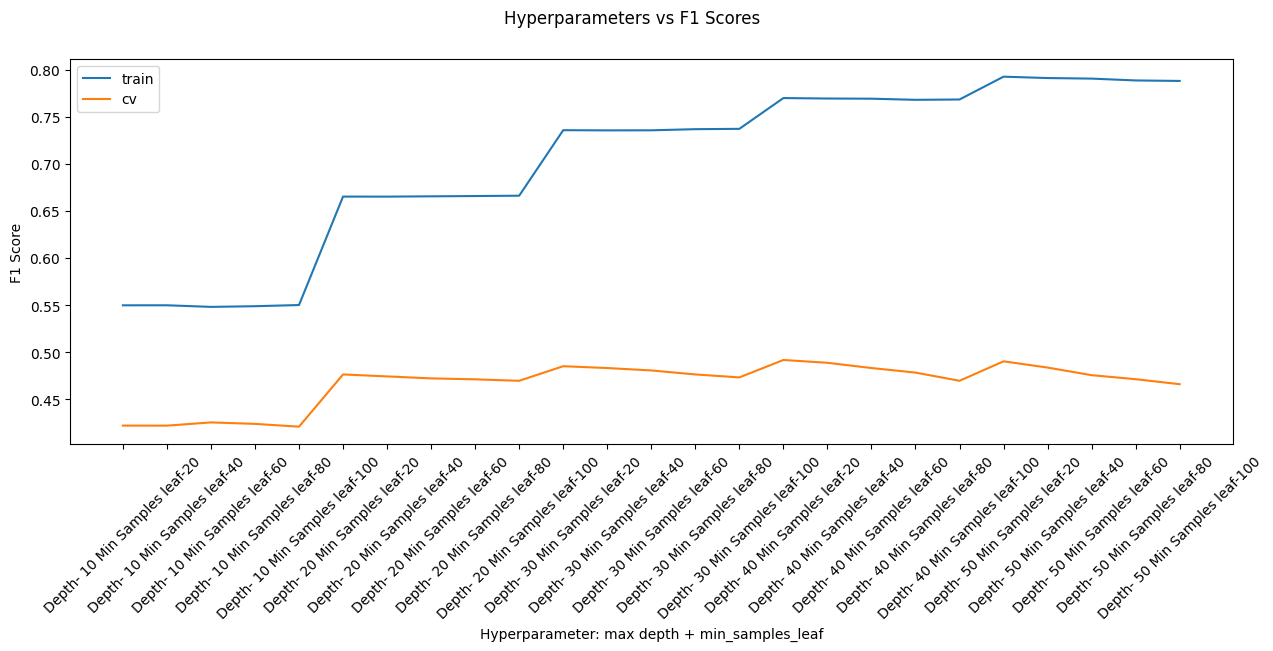

In [ ]:
# without hyper param tuning
# weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_over), y=y_over)
max_depth=[10, 20, 30, 40, 50]
min_samples=[20, 40, 60, 80, 100]
DTCmodel_under, xlabels, tr_f1s, cv_f1s=train_and_evaluate_decision_tree_classifier(max_depth, min_samples)
plot_train_and_cv_f1s(max_depth, min_samples, xlabels, tr_f1s, cv_f1s)

In [ ]:
# Predict on test set
ypred_dtc_u = DTCmodel_under.predict(tfidf_te)
ytrue= np.where(y_te['target'] >= 0.5, 1, 0)

Text(149.72222222222223, 0.5, 'true value')

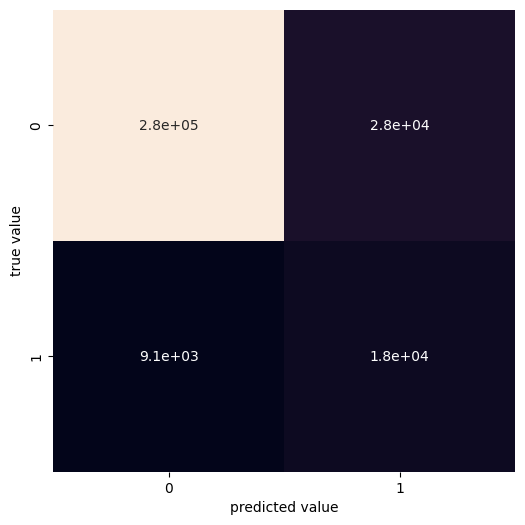

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
mat = confusion_matrix(ytrue, ypred_dtc_u)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# Classification report
cr= classification_report(ytrue, ypred_dtc_u)
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94    311363
           1       0.39      0.66      0.49     27051

    accuracy                           0.89    338414
   macro avg       0.68      0.79      0.71    338414
weighted avg       0.92      0.89      0.90    338414



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
RFmodel = RandomForestRegressor(n_estimators=100, random_state=1, max_depth=10, criterion="friedman_mse" )
RFmodel.fit(tfidf_train, y_train, sample_weight=sample_weights)

### Logistic Regression


##### Training the model

In [ ]:
#Converting ytrain to 0 and 1 for Logistic regression
ytrainbin = np.where(y_train['target'] >= 0.5, 1, 0)

In [ ]:
#Training Logistic regression Classifier
logregmodel = LogisticRegression(C=1, solver="sag", max_iter=200)
logregmodel.fit(tfidf_train, ytrainbin)

LogisticRegression(C=1, max_iter=200, solver='sag')

##### Make predictions and get results for test dataset

In [ ]:
test_pred = logregmodel.predict(tfidf_te)

In [ ]:
ytrue= np.where(y_te['target'] >= 0.5, 1, 0)

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')
Xte_under, yte_under = undersample.fit_resample(tfidf_te, ytrue)

In [ ]:
ypred_u= logregmodel.predict(Xte_under)

Text(149.72222222222223, 0.5, 'true value')

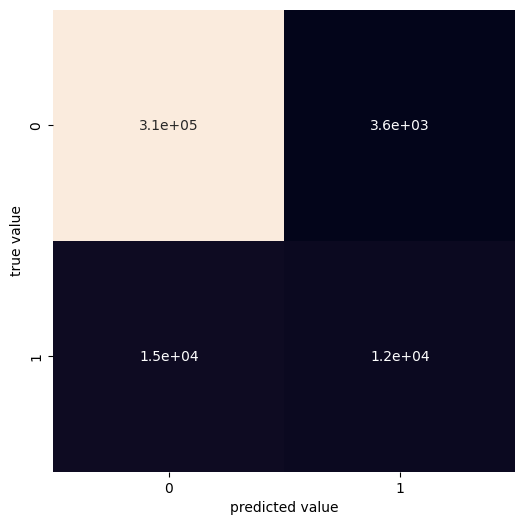

In [ ]:
plt.figure(figsize=(8, 6))
mat = confusion_matrix(ytrue, test_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

Text(149.72222222222223, 0.5, 'true value')

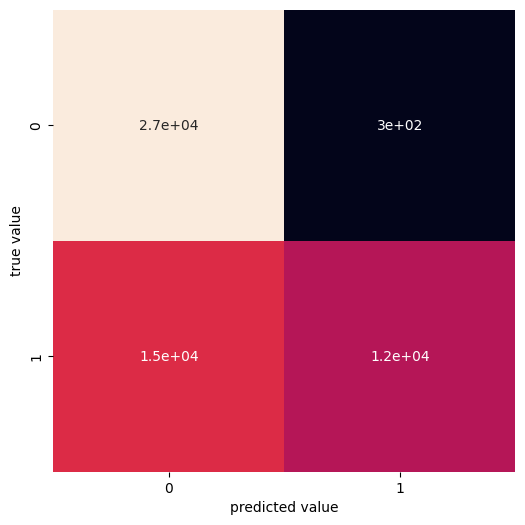

In [ ]:
plt.figure(figsize=(8, 6))
mat = confusion_matrix(yte_under, ypred_u)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# Balanced test set
cr= classification_report(yte_under, ypred_u)
print(cr)

              precision    recall  f1-score   support

           0       0.64      0.99      0.78     27051
           1       0.98      0.45      0.61     27051

    accuracy                           0.72     54102
   macro avg       0.81      0.72      0.70     54102
weighted avg       0.81      0.72      0.70     54102



In [ ]:
# Imbalanced
cr= classification_report(ytrue, test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    311363
           1       0.77      0.45      0.57     27051

    accuracy                           0.95    338414
   macro avg       0.86      0.72      0.77    338414
weighted avg       0.94      0.95      0.94    338414



In [ ]:
# Under sampled
cr= classification_report(ytrue, test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    311363
           1       0.41      0.83      0.55     27051

    accuracy                           0.89    338414
   macro avg       0.70      0.86      0.74    338414
weighted avg       0.94      0.89      0.91    338414



In [ ]:
# Oversampled
cr= classification_report(ytrue, test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    311363
           1       0.42      0.81      0.55     27051

    accuracy                           0.90    338414
   macro avg       0.70      0.86      0.75    338414
weighted avg       0.94      0.90      0.91    338414



### XGBoost

In [ ]:
!pip install optuna
import optuna

In [8]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

##### Training the model

In [ ]:
# #using optuna to find the best hyper params (credits for code: https://www.kaggle.com/code/mstsvgram/simple-sentiment-analysis-with-xgboost#Modelling)
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)}
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#     cv_scores = []
#     for train_index, valid_index in skf.split(X_train_xgb, y_train_xgb):
#         X_cv, X_valid = X_train_xgb[train_index], X_train_xgb[valid_index]
#         y_cv, y_valid = y_train_xgb[train_index], y_train_xgb[valid_index]
#         model = xgb.XGBClassifier(
#             **params,
#             eval_metric="logloss",
#             random_state=1,
#             #enable_categorical=True
#             )
#         model.fit(X_cv, y_cv)
#         preds = model.predict(X_valid)
#         acc = accuracy_score(y_valid, preds)
#         cv_scores.append(acc)
#     return np.mean(cv_scores)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# print("Best hyperparameters:", study.best_params)
# print("Best CV Accuracy:", study.best_value)


In [9]:
X_train_xgb= tfidf_train
X_cv_xgb= tfidf_cv
y_train_xgb=np.where(y_train['target'] >= 0.5, 1, 0)
y_cv_xgb= np.where(y_cv['target'] >= 0.5, 1, 0)


In [11]:
best_param = {
    'n_estimators': 15,  # Reduced number of trees
    'max_depth': 5,  # Smaller tree depth
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'subsample': 0.85,
    'min_child_weight': 1
}
model = xgb.XGBClassifier(
            **best_param,
            tree_method="hist",
            eval_metric="logloss",
            random_state=1)

In [ ]:
from sklearn.metrics import log_loss

batch_size=100000
for i in range(0, X_train_xgb.shape[0], batch_size):
    batch_X = X_train_xgb[i:i+batch_size]
    batch_y = y_train_xgb[i:i+batch_size]
    if i == 0:
        model.fit(batch_X, batch_y)
    else:
        model.fit(batch_X, batch_y, xgb_model=model.get_booster())

    val_preds = model.predict_proba(X_cv_xgb)[:, 1]
    val_loss = log_loss(y_cv_xgb, val_preds)
    print(f"Validation Log Loss after batch {i // batch_size + 1}: {val_loss:.4f}")

Validation Log Loss after batch 1: 0.2318
Validation Log Loss after batch 2: 0.2135
Validation Log Loss after batch 3: 0.2035
Validation Log Loss after batch 4: 0.1969


##### Make predictions and get results for test dataset

In [ ]:
ypred_xgb = model.predict(tfidf_te)
ytrue= np.where(y_te['target'] >= 0.5, 1, 0)
acc = accuracy_score(ytrue, ypred_xgb)

In [ ]:
acc

0.9344648862044714

Text(149.72222222222223, 0.5, 'true value')

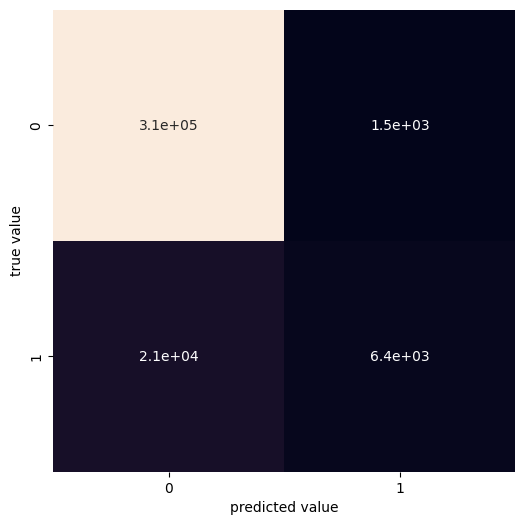

In [ ]:
plt.figure(figsize=(8, 6))
mat = confusion_matrix(ytrue, ypred_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
cr= classification_report(ytrue, ypred_xgb)
print(cr)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    311363
           1       0.81      0.24      0.36     27051

    accuracy                           0.93    338414
   macro avg       0.87      0.62      0.67    338414
weighted avg       0.93      0.93      0.92    338414



In [12]:
# With oversampled balanced dataset
from sklearn.metrics import log_loss

batch_size = 200000
unique_classes = np.unique(y_over)
for i in range(0, X_over.shape[0], batch_size):
    # print(i)
    batch_X = X_over[i:i+batch_size]
    batch_y = y_over[i:i+batch_size]

    # Check if batch contains all classes
    if not np.all(np.isin(unique_classes, np.unique(batch_y))):
        continue  # Skip batches with missing classes
    # print((batch_X.shape[0]))
    if i == 0:
        model.fit(batch_X, batch_y)
    else:
        model.fit(batch_X, batch_y, xgb_model=model.get_booster())

    val_preds = model.predict_proba(X_cv_xgb)[:, 1]
    val_loss = log_loss(y_cv_xgb, val_preds)
    print(f"Validation Log Loss after batch {i // batch_size + 1}: {val_loss:.4f}")


Validation Log Loss after batch 1: 0.2318
Validation Log Loss after batch 2: 0.2135
Validation Log Loss after batch 3: 0.2035
Validation Log Loss after batch 4: 0.1969
Validation Log Loss after batch 5: 0.1916
Validation Log Loss after batch 6: 0.8923


In [13]:
ypred_xgb = model.predict(tfidf_te)
ytrue= np.where(y_te['target'] >= 0.5, 1, 0)
acc = accuracy_score(ytrue, ypred_xgb)

Text(149.72222222222223, 0.5, 'true value')

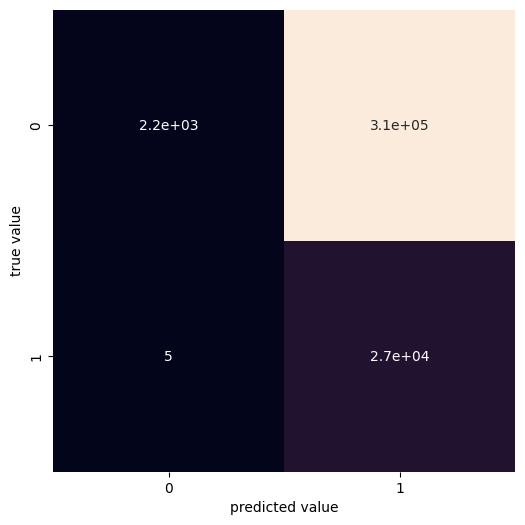

In [14]:
plt.figure(figsize=(8, 6))
mat = confusion_matrix(ytrue, ypred_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [15]:
cr= classification_report(ytrue, ypred_xgb)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.01      0.01    311363
           1       0.08      1.00      0.15     27051

    accuracy                           0.09    338414
   macro avg       0.54      0.50      0.08    338414
weighted avg       0.92      0.09      0.02    338414



### Predict the toxicity score of the tweets: Decision Tree

##### Training and Validation

Here we'll use weighted decision tree to handle the imbalance in our dataset. First we calculate the weights to be applied based on our training data and then use them while fitting our decision tree to the training data.

We will iterate over different permutation and combinations of max_depth, min_samples parameters to find the best model (one with lowest RMSE)

In [ ]:
# without hyper param tuning
weights = compute_sample_weight(class_weight='balanced', y=y_train)
DTmodel = DecisionTreeRegressor(criterion="friedman_mse", random_state=1, max_depth=9, min_samples_leaf=100)
DTmodel.fit(tfidf_train, y_train, sample_weight=weights) # Train

preds = DTmodel.predict(tfidf_train) # Get predictions
err = (mean_squared_error(y_train['target'], preds))** 0.5 # Calculate error on trainset
print("Root Mean Squared Error on train set: ", err)

preds = DTmodel.predict(tfidf_cv) # Get predictions on CV set
err = (mean_squared_error(y_cv['target'], preds)** 0.5) # Calculate error on cv set
print("Root Mean Squared Error on cv set: ", err)

Root Mean Squared Error on train set:  0.33560759381837246
Root Mean Squared Error on cv set:  0.3366233447151235


In [ ]:
def train_and_evaluate_decision_tree(max_depth, min_samples):
  xlabels = []
  tr_errors = []
  cv_errors = []
  best_model = None
  best_error = 100
  for d in max_depth:
      for samp in min_samples:
          xlabels.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
          print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

          model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
          model.fit(tfidf_train, y_train, sample_weight=weights) # Train

          preds = model.predict(tfidf_train) # Get predictions
          err = (mean_squared_error(y_train['target'], preds))** 0.5 # Calculate error on trainset
          tr_errors.append(err)
          print("Root Mean Squared Error on train set: ", err)

          preds = model.predict(tfidf_cv) # Get predictions on CV set
          err = (mean_squared_error(y_cv['target'], preds)** 0.5) # Calculate error on cv set
          cv_errors.append(err)
          print("Root Mean Squared Error on cv set: ", err)

          if err < best_error: # Get best model trained
              best_error = err
              best_model = model

          print("-"*50)
  return best_model, xlabels, tr_errors, cv_errors


def plot_train_and_cv_MSE(max_depth, min_samples, xlabels, tr_errors, cv_errors):
  plt.figure(figsize=(15,5))
  plt.suptitle("Hyperparameters vs MSE")
  plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
  plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
  plt.legend(['train', 'cv'])
  plt.xticks(range(len(max_depth) * len(min_samples)), xlabels, rotation=45)
  plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
  plt.ylabel('Root Mean Squared Error')
  plt.show()

In [ ]:
# Finding the right hyperparameters
max_depth = [10, 20, 30]
min_samples = [10, 100, 1000]
best_model, xlabels, tr_errors, cv_errors= train_and_evaluate_decision_tree(max_depth, min_samples)

Depth- 10 Min Samples leaf-10 :
Root Mean Squared Error on train set:  0.3975593666070414
Root Mean Squared Error on cv set:  0.3976303983114323
--------------------------------------------------
Depth- 10 Min Samples leaf-100 :
Root Mean Squared Error on train set:  0.39770829424763915
Root Mean Squared Error on cv set:  0.39776239155321075
--------------------------------------------------
Depth- 10 Min Samples leaf-1000 :
Root Mean Squared Error on train set:  0.40425208992766165
Root Mean Squared Error on cv set:  0.4043609121277016
--------------------------------------------------
Depth- 20 Min Samples leaf-10 :


In [ ]:
plot_train_and_cv_MSE(max_depth, min_samples, xlabels, tr_errors, cv_errors)

##### Feature Importance:

In [ ]:
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.361735
idiot,0.239291
pathet,0.063674
fool,0.062847
moron,0.058367
white,0.055197
hypocrit,0.051642
dumb,0.051051
crap,0.045049
racist,0.004351


##### Make predictions and get results for test dataset

In [ ]:
ytrue_dt= y_te['target']

In [ ]:
ypred_dt= DTmodel.predict(tfidf_te)

In [ ]:
(mean_squared_error(ytrue_dt, ypred_dt))** 0.5

0.3362064054319331

In [ ]:
# Scatter plot of actual and predicted values to visualise the differences
plt.scatter(ytrue_dt, ypred_dt, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual")
plt.show()